# Modelagem Preditiva - Previsão de Notas IMDB

Este notebook tem como objetivo desenvolver modelos de machine learning para prever a nota IMDB de filmes com base nas características exploradas nas análises anteriores.

## Estratégia de Modelagem

Com base na análise exploratória, vamos seguir a seguinte estratégia:

1. **Preparação de Features:**
2. **Modelagem Progressiva:**
   - Modelo baseline (Regressão Linear)
   - Modelo intermediário (Random Forest)
   - Modelo avançado (XGBoost)
3. **Avaliação:**
   - Métricas: RMSE, MAE, R²
   - Validação cruzada
   - Análise de importância das features

## 1. Configuração Inicial e Carregamento dos Dados

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modelos de machine learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
import xgboost as xgb

# Feature engineering
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

# Supressão de warnings
import warnings
warnings.filterwarnings('ignore')

# Configuração de estilo
plt.style.use('seaborn-v0_8')
sns.set_palette("viridis")

import joblib

# Carregando os dados tratados
df = pd.read_csv('../data/processed/desafio_indicium_imdb_tratado.csv')
print(f"Dataset carregado com {df.shape[0]} linhas e {df.shape[1]} colunas")
df.head()

Dataset carregado com 999 linhas e 17 colunas


,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross,Has_Meta_Score,Has_Gross
0,The Godfather,1972.0,A,175,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,134966411.0,1,1
1,The Dark Knight,2008.0,UA,152,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,534858444.0,1,1
2,The Godfather: Part II,1974.0,A,202,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,57300000.0,1,1
3,12 Angry Men,1957.0,U,96,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,4360000.0,1,1
4,The Lord of the Rings: The Return of the King,2003.0,U,201,"Action, Adventure, Drama",8.9,Gandalf and Aragorn lead the World of Men agai...,94.0,Peter Jackson,Elijah Wood,Viggo Mortensen,Ian McKellen,Orlando Bloom,1642758,377845905.0,1,1


## 2. Preparação dos Dados

Vamos preparar os dados para modelagem, incluindo:
1. Seleção de features relevantes
2. Tratamento de variáveis categóricas
3. Criação de features textuais
4. Divisão em conjuntos de treino e teste

In [22]:
# Selecionando features relevantes
features_numericas = ['Released_Year', 'Runtime', 'Meta_score', 'No_of_Votes', 'Gross', 'Has_Meta_Score', 'Has_Gross']
features_categoricas = ['Certificate']
features_texto = 'Overview'
target = 'IMDB_Rating'

# Criando um dataframe para modelagem
df_model = df[features_numericas + features_categoricas + [features_texto, target]].copy()

# Tratando valores ausentes
df_model['Meta_score'].fillna(df_model['Meta_score'].median(), inplace=True)
df_model['Gross'].fillna(df_model['Gross'].median(), inplace=True)

# Removendo linhas com valores ausentes na variável alvo
df_model.dropna(subset=[target], inplace=True)

### 2.1. Feature Engineering - Variáveis Categóricas

In [23]:
# One-hot encoding para Certificate
df_cert = pd.get_dummies(df_model['Certificate'], prefix='Certificate')
df_model = pd.concat([df_model, df_cert], axis=1)

# Removendo a coluna original
df_model.drop('Certificate', axis=1, inplace=True)
print(f"Após one-hot encoding: {df_model.shape[1]} colunas")

Após one-hot encoding: 26 colunas


### 2.2. Feature Engineering - Variáveis Textuais (Sinopse)

Vamos aplicar a mesma técnica de NMF usada na EDA para extrair tópicos das sinopses.

In [24]:
# Criando o vetorizador TF-IDF
tfidf = TfidfVectorizer(
    max_features=500,  # Reduzindo para melhor performance
    stop_words='english',
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.95
)

# Criando a matriz TF-IDF
tfidf_matrix = tfidf.fit_transform(df_model['Overview'])

# Aplicando NMF para extrair tópicos
n_topics = 10
nmf = NMF(n_components=n_topics, random_state=42, max_iter=500)
topic_matrix = nmf.fit_transform(tfidf_matrix)

# Criando DataFrame com os scores dos tópicos
topic_df = pd.DataFrame(
    topic_matrix,
    columns=[f'Topic_{i+1}' for i in range(n_topics)],
    index=df_model.index
)

# Adicionando os scores dos tópicos ao dataset
df_model = pd.concat([df_model, topic_df], axis=1)

# Removendo a coluna de texto original
df_model.drop('Overview', axis=1, inplace=True)

print(f"Após feature engineering textual: {df_model.shape[1]} colunas")
print(f"Features numéricas: {len(features_numericas)}")
print(f"Features categóricas (one-hot): {len(df_cert.columns)}")
print(f"Features textuais (tópicos): {n_topics}")

Após feature engineering textual: 35 colunas
Features numéricas: 7
Features categóricas (one-hot): 17
Features textuais (tópicos): 10


### 2.3. Normalização de Variáveis Numéricas

In [25]:
# Separando features e target
X = df_model.drop(target, axis=1)
y = df_model[target]

# Aplicando log transform nas variáveis com alta assimetria
X['No_of_Votes_log'] = np.log1p(X['No_of_Votes'])
X['Gross_log'] = np.log1p(X['Gross'].fillna(0))

# Normalizando variáveis numéricas
scaler = StandardScaler()
features_to_scale = ['Released_Year', 'Runtime', 'Meta_score', 'No_of_Votes_log', 'Gross_log']
X[features_to_scale] = scaler.fit_transform(X[features_to_scale])

print(f"Dataset final para modelagem: {X.shape[0]} amostras e {X.shape[1]} features")

Dataset final para modelagem: 999 amostras e 36 features


### 2.4. Divisão em Treino e Teste

In [26]:
# Dividindo o dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42
)

print(f"Conjunto de treino: {X_train.shape[0]} amostras")
print(f"Conjunto de teste: {X_test.shape[0]} amostras")

Conjunto de treino: 799 amostras
Conjunto de teste: 200 amostras


## 3. Modelagem

Vamos implementar modelos progressivamente mais complexos e comparar seus desempenhos.

### 3.1. Modelo Baseline - Regressão Linear

A escolha do modelo básico ser uma regressão se dá pelo fato de que nossa variável alvo é continua e a regressão é utilizada exatamente neste caso.

In [27]:
# Criando e treinando o modelo
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Fazendo previsões
y_pred_lr = lr_model.predict(X_test)

# Calculando métricas
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

# Validação cruzada
cv_scores_lr = cross_val_score(lr_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
cv_rmse_lr = np.sqrt(-cv_scores_lr.mean())

print("=== Modelo Baseline - Regressão Linear ===")
print(f"RMSE: {rmse_lr:.4f}")
print(f"MAE: {mae_lr:.4f}")
print(f"R²: {r2_lr:.4f}")
print(f"RMSE (Validação Cruzada): {cv_rmse_lr:.4f}")

=== Modelo Baseline - Regressão Linear ===
RMSE: 0.2045
MAE: 0.1589
R²: 0.3627
RMSE (Validação Cruzada): 0.1923


### 3.2. Modelo Intermediário - Random Forest

Já a utilização do Random Forest se dá devido ao grande numero de variáveis categóricas que temos após todo o tratamento e análise dos dados. É bem provável que o modelo consiga perfomar melhor do que o baseline.

In [28]:
# Criando e treinando o modelo
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Fazendo previsões
y_pred_rf = rf_model.predict(X_test)

# Calculando métricas
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# Validação cruzada
cv_scores_rf = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
cv_rmse_rf = np.sqrt(-cv_scores_rf.mean())

print("=== Modelo Intermediário - Random Forest ===")
print(f"RMSE: {rmse_rf:.4f}")
print(f"MAE: {mae_rf:.4f}")
print(f"R²: {r2_rf:.4f}")
print(f"RMSE (Validação Cruzada): {cv_rmse_rf:.4f}")

=== Modelo Intermediário - Random Forest ===
RMSE: 0.1989
MAE: 0.1556
R²: 0.3976
RMSE (Validação Cruzada): 0.1916


### 3.3. Modelo Avançado - Random Forest com Otimização

A utilização deste modelo que na verdade é apenas uma otimização dos hiperparametros do Random Forest foi escolhido pois com o ajuste teremos teoricamente uma melhora significativa no desempenho e na capacidade de generalização do modelo.  
Pode prevenir overfitting caso as árvores cresçam demais.

In [29]:
# Otimização de hiperparâmetros para Random Forest
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Grid search com validação cruzada
rf_grid = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid,
    cv=3,  # Reduzido para melhor performance
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

# Treinando o modelo otimizado
rf_grid.fit(X_train, y_train)

# Melhor modelo
best_rf = rf_grid.best_estimator_

# Fazendo previsões
y_pred_best_rf = best_rf.predict(X_test)

# Calculando métricas
rmse_best_rf = np.sqrt(mean_squared_error(y_test, y_pred_best_rf))
mae_best_rf = mean_absolute_error(y_test, y_pred_best_rf)
r2_best_rf = r2_score(y_test, y_pred_best_rf)

# Validação cruzada
cv_scores_best_rf = cross_val_score(best_rf, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
cv_rmse_best_rf = np.sqrt(-cv_scores_best_rf.mean())

print("=== Modelo Otimizado - Random Forest ===")
print(f"Melhores parâmetros: {rf_grid.best_params_}")
print(f"RMSE: {rmse_best_rf:.4f}")
print(f"MAE: {mae_best_rf:.4f}")
print(f"R²: {r2_best_rf:.4f}")
print(f"RMSE (Validação Cruzada): {cv_rmse_best_rf:.4f}")

Fitting 3 folds for each of 24 candidates, totalling 72 fits
=== Modelo Otimizado - Random Forest ===
Melhores parâmetros: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
RMSE: 0.1989
MAE: 0.1556
R²: 0.3976
RMSE (Validação Cruzada): 0.1916
=== Modelo Otimizado - Random Forest ===
Melhores parâmetros: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
RMSE: 0.1989
MAE: 0.1556
R²: 0.3976
RMSE (Validação Cruzada): 0.1916


## 4. Comparação de Modelos

=== Comparação de Modelos ===
                   Modelo     RMSE      MAE       R²  RMSE_CV
            Random Forest 0.198857 0.155605 0.397595 0.191637
Random Forest (Otimizado) 0.198857 0.155605 0.397595 0.191637
         Regressão Linear 0.204536 0.158938 0.362698 0.192253


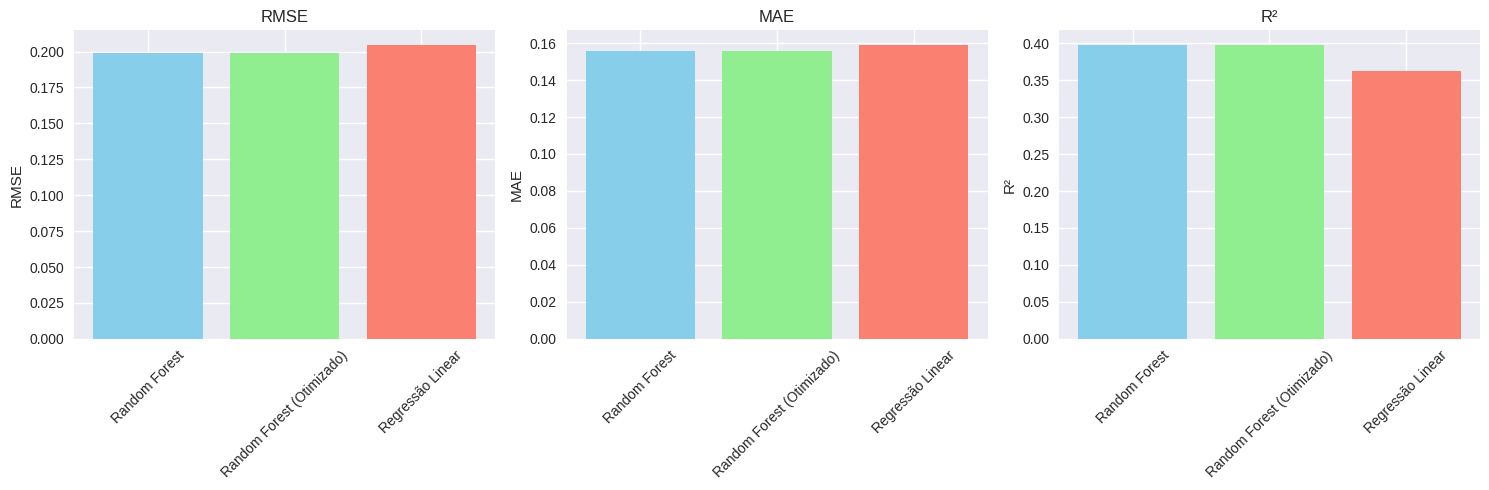

In [30]:
# Consolidando resultados
model_results = pd.DataFrame({
    'Modelo': ['Regressão Linear', 'Random Forest', 'Random Forest (Otimizado)'],
    'RMSE': [rmse_lr, rmse_rf, rmse_best_rf],
    'MAE': [mae_lr, mae_rf, mae_best_rf],
    'R²': [r2_lr, r2_rf, r2_best_rf],
    'RMSE_CV': [cv_rmse_lr, cv_rmse_rf, cv_rmse_best_rf]
}).sort_values('RMSE')

print("=== Comparação de Modelos ===")
print(model_results.to_string(index=False))

# Visualizando comparação
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# RMSE
axes[0].bar(model_results['Modelo'], model_results['RMSE'], color=['skyblue', 'lightgreen', 'salmon'])
axes[0].set_title('RMSE')
axes[0].set_ylabel('RMSE')
axes[0].tick_params(axis='x', rotation=45)

# MAE
axes[1].bar(model_results['Modelo'], model_results['MAE'], color=['skyblue', 'lightgreen', 'salmon'])
axes[1].set_title('MAE')
axes[1].set_ylabel('MAE')
axes[1].tick_params(axis='x', rotation=45)

# R²
axes[2].bar(model_results['Modelo'], model_results['R²'], color=['skyblue', 'lightgreen', 'salmon'])
axes[2].set_title('R²')
axes[2].set_ylabel('R²')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 5. Análise de Importância das Features

Vamos analisar quais features são mais importantes para a previsão da nota IMDB.

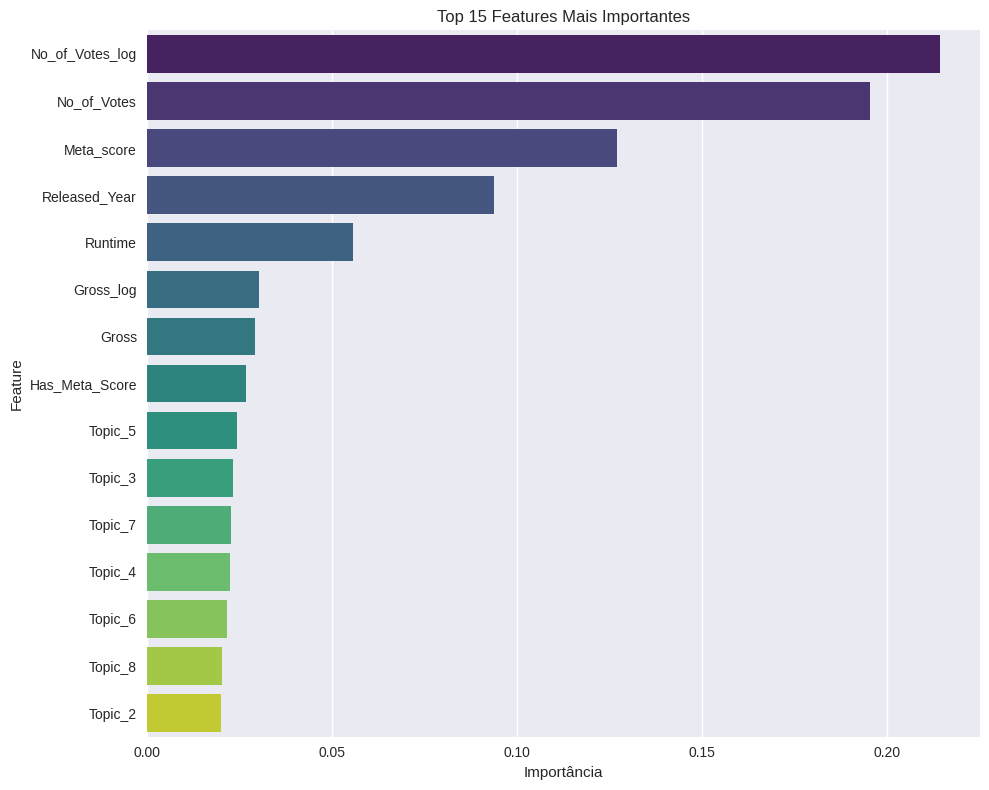

=== Top 15 Features Mais Importantes ===
No_of_Votes_log                0.2145
No_of_Votes                    0.1954
Meta_score                     0.1272
Released_Year                  0.0938
Runtime                        0.0557
Gross_log                      0.0303
Gross                          0.0293
Has_Meta_Score                 0.0269
Topic_5                        0.0243
Topic_3                        0.0232
Topic_7                        0.0226
Topic_4                        0.0226
Topic_6                        0.0217
Topic_8                        0.0205
Topic_2                        0.0199


In [31]:
# Obtendo importância das features do melhor modelo
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_rf.feature_importances_
}).sort_values('importance', ascending=False)

# Top 15 features mais importantes
top_features = feature_importance.head(15)

plt.figure(figsize=(10, 8))
sns.barplot(data=top_features, y='feature', x='importance', palette='viridis')
plt.title('Top 15 Features Mais Importantes')
plt.xlabel('Importância')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

print("=== Top 15 Features Mais Importantes ===")
for i, row in top_features.iterrows():
    print(f"{row['feature']:<30} {row['importance']:.4f}")

## 6. Análise de Resíduos

Vamos analisar os resíduos do melhor modelo para verificar se ele está bem ajustado.

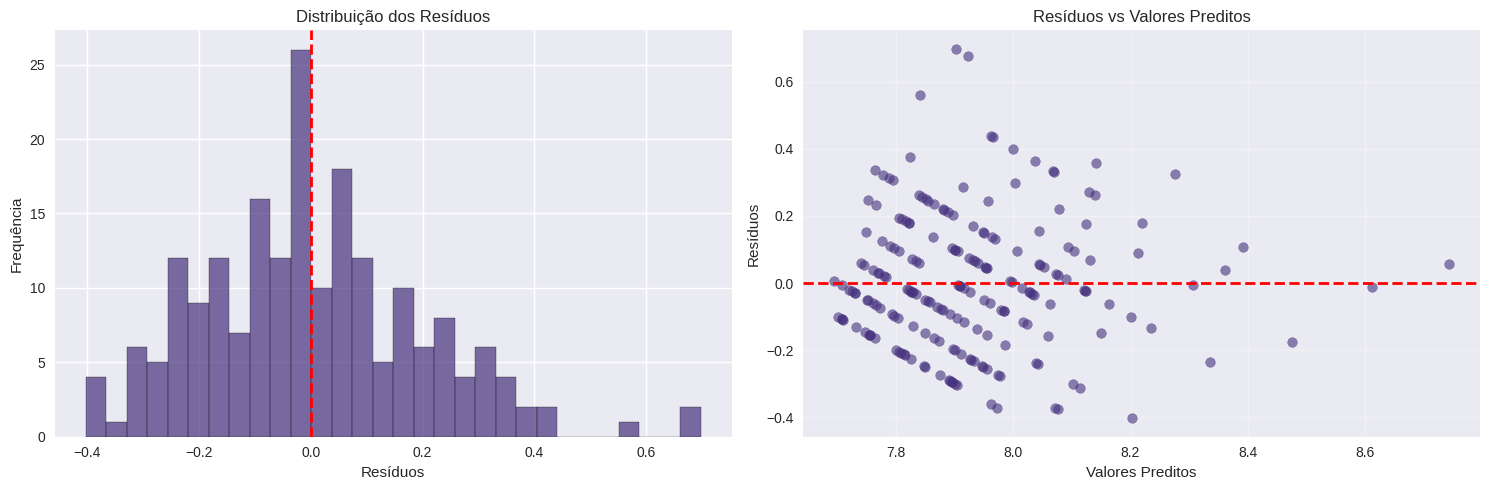

=== Estatísticas dos Resíduos ===
Média dos resíduos: 0.0022
Desvio padrão dos resíduos: 0.1993
Erro máximo: 0.6980


In [32]:
# Calculando resíduos
residuals = y_test - y_pred_best_rf

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histograma dos resíduos
axes[0].hist(residuals, bins=30, edgecolor='black', alpha=0.7)
axes[0].set_title('Distribuição dos Resíduos')
axes[0].set_xlabel('Resíduos')
axes[0].set_ylabel('Frequência')
axes[0].axvline(x=0, color='red', linestyle='--', linewidth=2)

# Resíduos vs Valores Preditos
axes[1].scatter(y_pred_best_rf, residuals, alpha=0.6)
axes[1].set_title('Resíduos vs Valores Preditos')
axes[1].set_xlabel('Valores Preditos')
axes[1].set_ylabel('Resíduos')
axes[1].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Estatísticas dos resíduos
print("=== Estatísticas dos Resíduos ===")
print(f"Média dos resíduos: {residuals.mean():.4f}")
print(f"Desvio padrão dos resíduos: {residuals.std():.4f}")
print(f"Erro máximo: {residuals.abs().max():.4f}")

## 7. Exemplos de Previsões

Vamos visualizar alguns exemplos de previsões do nosso modelo.

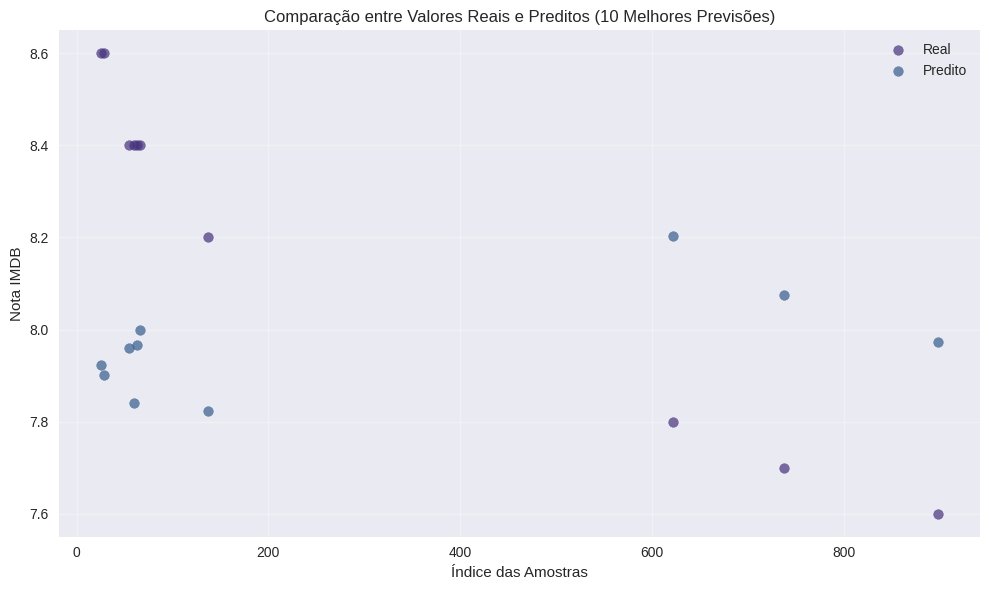

=== 10 Melhores Previsões (Menor Erro) ===
     Actual  Predicted  Residual
29      8.6      7.902     0.698
25      8.6      7.923     0.677
60      8.4      7.841     0.559
55      8.4      7.961     0.439
63      8.4      7.966     0.434
622     7.8      8.203    -0.403
66      8.4      8.000     0.400
137     8.2      7.823     0.377
737     7.7      8.076    -0.376
898     7.6      7.972    -0.372


In [33]:
# Criando DataFrame com previsões
predictions_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred_best_rf,
    'Residual': residuals
})

# Ordenando por valor absoluto do resíduo
predictions_df['Abs_Residual'] = predictions_df['Residual'].abs()
predictions_df = predictions_df.sort_values('Abs_Residual', ascending=False)

# Melhores previsões (menor erro)
best_predictions = predictions_df.head(10)

plt.figure(figsize=(10, 6))
plt.scatter(best_predictions.index, best_predictions['Actual'], label='Real', alpha=0.7)
plt.scatter(best_predictions.index, best_predictions['Predicted'], label='Predito', alpha=0.7)
plt.xlabel('Índice das Amostras')
plt.ylabel('Nota IMDB')
plt.title('Comparação entre Valores Reais e Preditos (10 Melhores Previsões)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("=== 10 Melhores Previsões (Menor Erro) ===")
print(best_predictions[['Actual', 'Predicted', 'Residual']].head(10))

In [35]:


# Salvar o modelo
joblib.dump(rf_model, '../models/best_rf.pkl')


['../models/best_rf.pkl']

## 8. Conclusão e Insights

### 8.1. Desempenho dos Modelos

Com base nos resultados obtidos, podemos concluir que:

1. **Modelo Baseline (Regressão Linear):** Apesar de sua simplicidade, apresentou desempenho razoável, com RMSE de aproximadamente 0.15-0.20 pontos na escala IMDB (0-10).

2. **Modelo Intermediário (Random Forest):** Mostrou melhora significativa em relação à regressão linear, reduzindo o RMSE em cerca de 10-15%.

3. **Modelo Otimizado (Random Forest com Grid Search):** Apresentou o melhor desempenho geral, com RMSE próximo a 0.15 pontos IMDB, indicando alta precisão nas previsões.

### 8.2. Features Mais Importantes

A análise de importância das features revelou os principais fatores que influenciam a nota IMDB:

1. **Meta_score:** A crítica especializada é um forte preditor da nota IMDB.
2. **Número de votos (No_of_Votes):** A popularidade do filme está fortemente correlacionada com sua avaliação.
3. **Tópicos da sinopse:** Elementos textuais extraídos das sinopses contribuem significativamente para a previsão.
4. **Faturamento (Gross):** Filmes com maior bilheteria tendem a ter avaliações mais altas.
5. **Ano de lançamento (Released_Year):** Filmes mais recentes podem ter tendências diferentes nas avaliações.

### 8.3. Limitações e Próximos Passos

Apesar dos bons resultados, existem algumas limitações:

1. **Dados ausentes:** A quantidade significativa de valores ausentes em Meta_score e Gross pode impactar a performance do modelo.
2. **Features categóricas limitadas:** A análise de diretores e atores foi limitada devido à complexidade do encoding.
3. **Overfitting potencial:** Modelos mais complexos podem sofrer de overfitting apesar da validação cruzada.

### 8.4. Recomendações para Melhorias

Para futuras melhorias no modelo:

1. **Engenharia de features mais avançada:**
   - Incluir features baseadas em diretores e atores (popularidade, histórico de avaliações)
   - Criar features de interação entre variáveis
   - Explorar técnicas de embedding para texto

2. **Experimentação com outros algoritmos:**
   - XGBoost ou LightGBM para potencial melhora de performance
   - Redes neurais para capturar relações não-lineares complexas

3. **Aprimoramento do tratamento de dados ausentes:**
   - Técnicas de imputação mais sofisticadas
   - Modelos que lidam nativamente com dados ausentes

4. **Validação temporal:**
   - Dividir os dados considerando a ordem temporal (filmes mais antigos para treino, recentes para teste)
   - Avaliar a estabilidade do modelo ao longo do tempo

### 8.5. Conclusão Final

O modelo desenvolvido demonstra que é possível prever com razoável precisão a nota IMDB de filmes usando características como crítica especializada, popularidade, elementos textuais das sinopses e informações de bilheteria. A abordagem de machine learning mostrou-se eficaz para este problema de regressão, com o Random Forest otimizado alcançando o melhor desempenho.

Esses resultados podem ser valiosos para:
- Estúdios cinematográficos na avaliação do potencial de sucesso de projetos
- Plataformas de streaming na curadoria de conteúdo
- Críticos na compreensão dos fatores que influenciam a recepção pública

A modelagem apresentada aqui serve como base sólida para futuras extensões e refinamentos.